In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from math import sqrt
from scipy.stats import variation

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Degraded image from Dataset

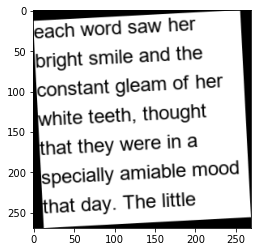

In [2]:
# path = '../../StandartImages/Train/DegradedImages/degraded_image0.png'
path = '../sample_images/multiline_text.png'
image = cv.imread(path)
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

plt.imshow(image, cmap='gray')
plt.show()
# plt.savefig('../sample_images/rotated_multiline_text.png')

In [3]:
def plot_x_bar(image: np.array):
    fig = plt.figure(figsize=(8, 6))
    
    x = [sum(1 - row / 255) for row in image]
    
    plt.grid(zorder=0)
    plt.bar([i for i in range(image.shape[0])], x, zorder=13, linewidth=0.0, color='k')
    plt.xlabel('i -- Number of row', fontsize=20)
    plt.ylabel('x -- Amount of black', fontsize=20)
    return fig

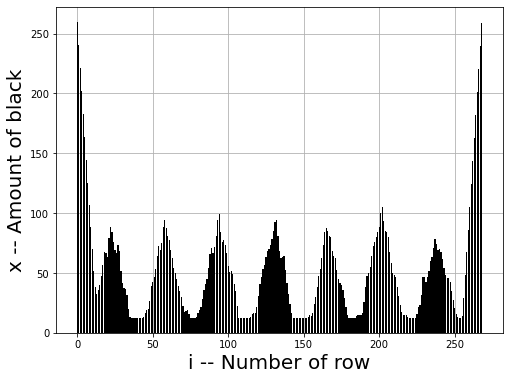

In [4]:
plot_x_bar(image)
plt.savefig("orig_x_bar.png", dpi=1000)

In [5]:
def rotate_and_cut_off(image: np.array, angle: float, center: (int, int)) -> np.ndarray:
    """
        Function rotates an image and cuts off black borders

        Args:
            image (np.array): tensor representing an image.
            angle (float): the angle of rotation is measured in degrees.
            center ((int, int)): center of rotation.
    """
    height, width = image.shape[:2]
    x, y = center

    theta = angle / 180.0 * np.math.pi
    cos_t = np.math.cos(theta)
    sin_t = np.math.sin(theta)
    M = np.float32([[cos_t, sin_t, x - x * cos_t - y * sin_t], [-sin_t, cos_t, y + x * sin_t - y * cos_t]])
    
    new_width = int(-height * np.abs(sin_t) + width * cos_t)
    new_height = int(height * cos_t - width * np.abs(sin_t))

    M[0, 2] += (new_width / 2) - x
    M[1, 2] += (new_height / 2) - y

    rotated = cv.warpAffine(image, M, (new_width, new_height))
    
    # rotated = cv.warpAffine(image, M, (width, height))
    return rotated

In [6]:
def make_image_horizontal(image: np.array, max_angle=5) -> np.ndarray:
    """
        Function rotates an image to make its text horizontal

        Args:
            image (np.array): tensor representing an image.
            max_angle (float): the max rotating angle to find the horizontal position
    """
    height, width = image.shape[:2]

    max_variation = 0
    best_angle = None

    for angle in np.linspace(-max_angle, max_angle, 21):
        M = cv.getRotationMatrix2D((width // 2, height // 2), angle, 1)
        rotated_img = cv.warpAffine(image, M, (width, height))

        x = [sum(1 - row / 255) for row in rotated_img]
        if variation(x) > max_variation:
            best_angle = angle
            max_variation = variation(x)

    horizontal_img = rotate_and_cut_off(image, best_angle, (width // 2, height // 2))
    return horizontal_img[2:-2]

### Horizontal image

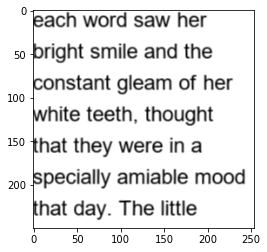

In [7]:
image = make_image_horizontal(image)

plt.imshow(image, cmap='gray')
plt.show()

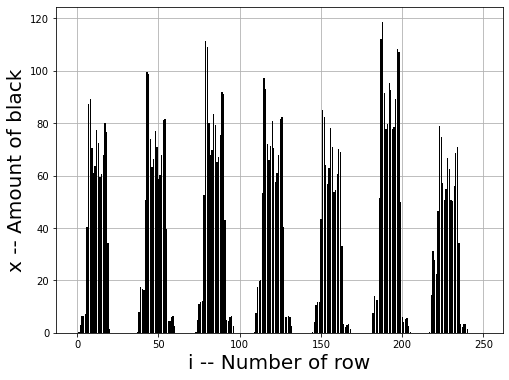

In [8]:
plot_x_bar(image)
plt.savefig("rotated_x_bar.png", dpi=1000)

In [9]:
def cut_image_into_text_lines(image: np.ndarray, number_of_lines=7, 
                              gradient_bound=0.3, show_plot=False) -> np.ndarray:
    """
    Function cuts a multi-line image to list of single-line images

    Args:
        image (np.ndarray): tensor representing an image
        number_of_lines (int): approximate number of text lines that image has
        deviation_bound (float): hyperparameter that regulates the increase
        in number of black pixels where text appears
    """
    # image = make_image_horizontal(image)
    plot_x_bar(image)
    
    c = 0
    q = 0

    height, width = image.shape[:2]
    # height of areas of the image where few black pixels are
    valley_size = int(height / (number_of_lines / 7 * 25))
    # height of areas of the image where number of black pixels starts to increase
    slope_size = int(height / (number_of_lines / 7 * 50))

    x = [sum(1 - row / 255) for row in image]
    prev_cut_index = -1
    cut_indices = [0]
    for i in range(valley_size + slope_size, len(x) - valley_size):
        valley = x[i - valley_size: i]
        gradient = (sum(x[i: i + slope_size]) - sum(x[i - slope_size: i])) / slope_size
        if np.mean(valley) < np.mean(x) - np.std(x) / 2 and gradient > gradient_bound * np.std(x):
            if prev_cut_index == -1 or i - prev_cut_index > valley_size:
                cut_indices.append(i)
                prev_cut_index = i
                if show_plot:
                    if c == 0:
                        plt.plot([i, i], [0, 135], 'k--', label='Final places of cuts')
                        c += 1
                    else:
                        plt.plot([i, i], [0, 135], 'k--')
            else:
                if show_plot:
                    if q == 0:
                        plt.plot([i, i], [0, 135], 'r-', alpha=0.5, label='Possible places of cuts')
                        q += 1
                    else:
                        plt.plot([i, i], [0, 135], 'r-', alpha=0.5)
    cut_indices.append(height)
#     if show_plot:
#         plt.plot([i for i in range(len(x))], x)
#         plt.show()
    single_line_images = []
    for j in range(len(cut_indices) - 1):
        single_line_images.append(image[cut_indices[j]: cut_indices[j + 1]])
        
    plt.title('Detecting text lines', fontsize=24)
    plt.legend(fontsize=16)

    return single_line_images

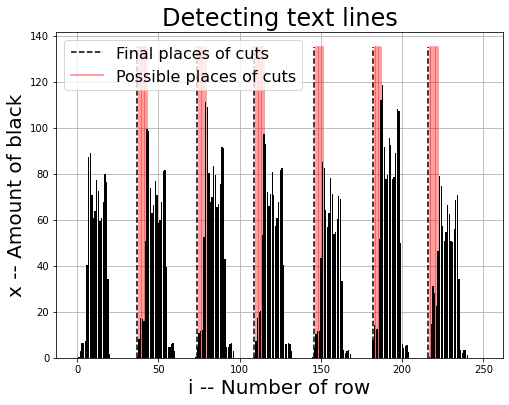

In [10]:
single_line_images = cut_image_into_text_lines(image, show_plot=True)
plt.savefig("where_cut.png", dpi=1000)

### Single-line images

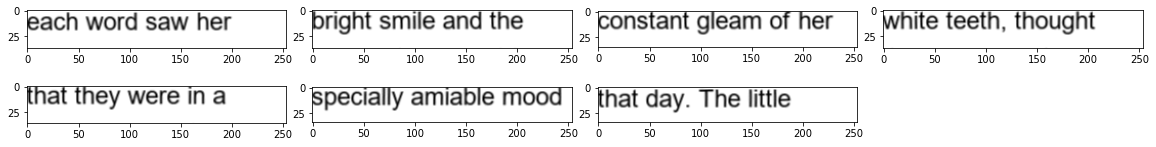

In [48]:
import matplotlib.gridspec as gridspec

fig, ax = plt.subplots(2, 4, figsize=(20, 5))
for i in range(4):
    ax[0, i].imshow(single_line_images[i], cmap="gray")
for i in range(3):
    ax[1, i].imshow(single_line_images[i + 4], cmap="gray")  

ax[1, 3].remove()
# gs = gridspec.GridSpec(2,4)
# for i in range(2):
#     for j in range(4):
#         k = i+j*2
#         if k < len(ax):
#             ax[k].set_position(gs[k].get_position(fig))
plt.tight_layout()
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.5, 
                    wspace=0.1, 
                    hspace=0.1)
plt.savefig('singleline_text.png')